# Visual Optimization
==================

This notebook aims at providing a visual understanding of the behaviour of two gradient-based optimizer (steepest descent and conjugate gradient) for linear systems of equations of the type:

$$\mathbf{d} = \mathbf{G} \mathbf{m}$$

where $\mathbf{G}$ is an $N \times N$ matrix. In this example we will use a toy N=2-dimensional problem.

In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scooby

from optutils import steepest_descent, conjgrad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's start by setting up the forward problem. We also compute the condition number of the operator $\mathbf{G}$. The further the conditioning number from 1 the further the behaviour of the two solvers we will use in the following

In [48]:
m = np.array([0., 0.])
G = np.array([[2., 1.], [1., 10.]])

print('G condition number %f' % np.linalg.cond(G))

G condition number 5.393540


Let's define now the cost function to optimize

In [49]:
m_min, m_max = (m[0] - 1.2, m[1] - 1.2), (m[0] + 1.2, m[1] + 1.2)
d = np.dot(G, m)

# cost function grid
nm1, nm2 = 101, 101
m1, m2 = np.mgrid[m_min[0]:m_max[1]:1j*nm1, m_min[1]:m_max[1]:1j*nm2]
mgrid = np.vstack((m1.ravel(), m2.ravel()))

J = np.linalg.norm(d[:, np.newaxis] - np.dot(G, mgrid), axis=0)
J = J.reshape(nm1, nm2)

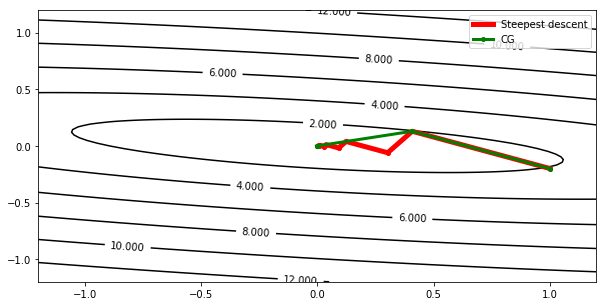

In [50]:
m0 = np.array([1, -0.2])
msd = steepest_descent(G, d, niter=10, m0=m0)
mcg = conjgrad(G, d, niter=10, m0=m0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cs = ax.contour(m1, m2, J, colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(msd[:, 0], msd[:, 1], '.-r', lw=5, ms=8, label='Steepest descent')
ax.plot(mcg[:, 0], mcg[:, 1], '.-g', lw=3, ms=8, label='CG')
ax.legend();

In [52]:
scooby.Report()

--------------------------------------------------------------------------------
  Date: Sun Jul 07 19:53:53 2019 CEST

            Darwin : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
            8.0 GB : RAM
           Jupyter : Environment

  Python 3.7.2 (default, Dec 29 2018, 00:00:04)  [Clang 4.0.1
  (tags/RELEASE_401/final)]

            1.15.4 : numpy
             1.2.1 : scipy
             7.2.0 : IPython
             3.0.2 : matplotlib
             0.4.1 : scooby
--------------------------------------------------------------------------------